## Collecte de données

### Fonctions

In [12]:
import urllib.request
import pandas as pd
from PIL import Image

def getDataFrame(JSON):
    columns   = ["label","format","link","path"]
    dataArray = []
    for data in JSON["results"]["bindings"]:
        link = data["image"]["value"]
        label = data["itemLabel"]["value"]
        format = str(link).split(".")[-1]
        path = "./images/" + label +"."+ format

        dataArray.append([label,format,link,path])


    return dataArray, columns

def writeExifData(dataframe):

    tags = ["label","imageWidth","imageHeight","model"]
    tagsWantedEXIF = [256,257,272]
    dataEXIF = []
    
    length = len(dataframe.index)
    for i in range(length):
        path = dataframe._get_value(i,'path')
        
        image = Image.open(path)
        exif = image.getexif()

        

        array = [dataframe._get_value(i,'label')]
        for tag in tagsWantedEXIF:
            array.append(exif.get(tag))
        dataEXIF.append(array)
    
    dataframe = pd.DataFrame(dataEXIF, columns=tags)
    with open("exif.json", "w") as outfile:
        outfile.write(dataframe.to_json())
    
    
        


def downloadImage(link, path):
    urllib.request.urlretrieve(link, path)






### Collecte des images

In [13]:
import urllib.request
import os
import json
import pandas as pd
import glob

# 
QUERY_LIMIT = 5
QUERY_JSON_PATH = "query.json"

# Récupération de la Query
url = "https://query.wikidata.org/sparql?query=SELECT%20%3Fitem%20%3FitemLabel%20%3Fimage%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ144%20.%0A%3Fitem%20wdt%3AP18%20%3Fimage%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D%0ALIMIT%20"+str(QUERY_LIMIT)+"&format=json"
response = urllib.request.urlopen(url)
responseJSON  = json.load(response)

# Création de la dataframe
array, columns = getDataFrame(responseJSON)
dataframe = pd.DataFrame(array, columns= columns)

# Création du fichier JSON 
with open(QUERY_JSON_PATH, "w") as outfile:
    outfile.write(dataframe.to_json())

# Vidage du dossier images
files = glob.glob('./images/*')
for f in files:
    os.remove(f)
        
# Telechargement des images
length = len(dataframe.index)
for i in range(length):
    link = dataframe._get_value(i,'link')
    path = dataframe._get_value(i,'path')
    downloadImage(link,path)


### Récupération des Métadonnées EXIF

In [14]:
writeExifData(pd.read_json(QUERY_JSON_PATH))

exifDataframe = pd.read_json("exif.json")
exifDataframe

,label,imageWidth,imageHeight,model
0,Sutter Brown,NaN,NaN,Canon PowerShot G12
1,Sykes,NaN,NaN,DSC-H50
2,Terry,NaN,NaN,None
3,Tillman,NaN,NaN,None
4,Titan,NaN,NaN,None


## Étiquetage et annotation

### Détermination Kmeans des couleurs dominantes

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np

N = 3

imagesDataframe = pd.read_json(QUERY_JSON_PATH)
meansArray = []

for path in imagesDataframe.path:

    img = Image.open(path).convert("RGB")
    imgArray = np.array(img.getdata())
    imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

    model=KMeans(n_clusters= N, n_init='auto')
    model.fit(imgDataframe)

    meansList = (np.floor(model.cluster_centers_)).tolist()
    meansArray.append(meansList)



meansDataframe = pd.DataFrame(meansArray,columns = [i for i in range(N)])

# Création du fichier JSON 
with open("color.json", "w") as outfile:
    outfile.write(meansDataframe.to_json())

meansDataframe



,0,1,2
0,"[166.0, 127.0, 106.0]","[218.0, 212.0, 204.0]","[86.0, 67.0, 66.0]"
1,"[109.0, 161.0, 94.0]","[23.0, 40.0, 25.0]","[178.0, 198.0, 192.0]"
2,"[22.0, 23.0, 22.0]","[190.0, 190.0, 189.0]","[97.0, 97.0, 97.0]"
3,"[137.0, 98.0, 87.0]","[195.0, 195.0, 185.0]","[95.0, 53.0, 45.0]"
4,"[89.0, 76.0, 70.0]","[145.0, 141.0, 134.0]","[177.0, 178.0, 183.0]"


### Option : affichage du Kmeans

[[0.54221915 0.54302411 0.54011206]
 [0.03291969 0.03396193 0.03004808]
 [0.85258903 0.85330598 0.85017659]
 [0.25572336 0.25633453 0.25379673]
 [0.64073466 0.64127959 0.63866605]
 [0.34528238 0.34579741 0.34295648]
 [0.17488979 0.17564085 0.17264091]
 [0.74824254 0.74865251 0.7456288 ]
 [0.09767215 0.09850361 0.09564077]
 [0.43876476 0.4393171  0.43655232]]


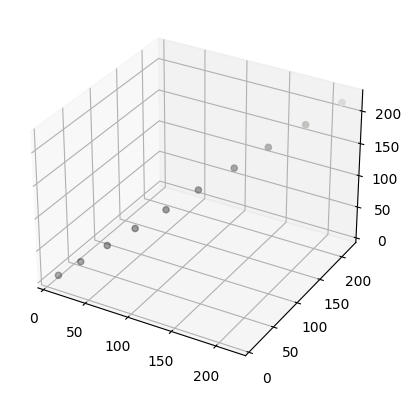

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

path = "./images/Terry.jpg"
N = 10

img = Image.open(path).convert("RGB")
imgArray = np.array(img.getdata())
imgDataframe = pd.DataFrame(imgArray, columns=["red","green","blue"])

model=KMeans(n_clusters= N, n_init='auto')
model.fit(imgDataframe)

x = imgArray.red
y = imgArray.green
z = imgArray.blue
c = model.cluster_center_[model.labels_]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x,y,z,c = )
print(model.cluster_centers_/255)
